In [13]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

In [14]:
BATCH_SIZE = 32
VAL_SIZE = 0.2
AMNT_BATCHS = 500
DATASET_SIZE = AMNT_BATCHS * BATCH_SIZE
EPOCHS = 20
NRO_MODELO = "modelo_3"

In [15]:
trainImages = keras.utils.image_dataset_from_directory(
    'places/',
    label_mode=None,
    image_size=(256,256),
    batch_size=BATCH_SIZE,
    shuffle=False).take(AMNT_BATCHS)

trainImages = trainImages.map( lambda x : x / 255 )

blurredTrainImages = keras.utils.image_dataset_from_directory(
    'blurredPlaces/',
    label_mode=None,
    image_size=(256,256),
    batch_size=BATCH_SIZE,
    shuffle=False).take(AMNT_BATCHS)

blurredTrainImages = blurredTrainImages.map( lambda x : x / 255 )

Found 36500 files belonging to 1 classes.
Found 36500 files belonging to 1 classes.


In [16]:
valSplit = int( (DATASET_SIZE / BATCH_SIZE) * VAL_SIZE )

train =  tf.data.Dataset.zip((blurredTrainImages, trainImages))

datasetTrain = train.skip(valSplit)
datasetValidation = train.take(valSplit)

In [18]:
input = layers.Input(shape=(256, 256, 3))

# Encoder
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(input)
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(32, (5, 5), activation="relu", padding="same")(x)
x = layers.Conv2D(3, (5, 5), activation="sigmoid", padding="same")(x)


# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

modelFile = open('checkpoints/' + NRO_MODELO + '/modelo.txt', 'w+')
autoencoder.summary(print_fn=lambda x: modelFile.write(x + '\n'))
modelFile.close()

In [19]:
def writeLog( file, epoch, log ):
    file.write(str(epoch) + ',' + str(log['loss'])+ ',' + str(log['val_loss']) + '\n')


In [20]:
modelCallback = tf.keras.callbacks.ModelCheckpoint(
        filepath='checkpoints/' + NRO_MODELO + '/model.ckpt',
        save_weights_only=True,
        verbose=1)

lossCkptFile = open('checkpoints/' + NRO_MODELO + '/loss.ckpt', 'a+')
lossCallback = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: writeLog( lossCkptFile, epoch, logs))

historia = autoencoder.fit(
    datasetTrain,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=datasetValidation,
    callbacks = [modelCallback, lossCallback]
)

lossCkptFile.close()

Epoch 1/20
400/400 [==============================] - ETA: 0s - loss: 0.5579
Epoch 1: saving model to checkpoints/modelo_3/model.ckpt
400/400 [==============================] - 115s 281ms/step - loss: 0.5579 - val_loss: 0.5433
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.5413
Epoch 2: saving model to checkpoints/modelo_3/model.ckpt
400/400 [==============================] - 122s 302ms/step - loss: 0.5413 - val_loss: 0.5445
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 0.5504
Epoch 3: saving model to checkpoints/modelo_3/model.ckpt
400/400 [==============================] - 99s 243ms/step - loss: 0.5504 - val_loss: 0.5351
Epoch 4/20
400/400 [==============================] - ETA: 0s - loss: 0.5293
Epoch 4: saving model to checkpoints/modelo_3/model.ckpt
400/400 [==============================] - 98s 242ms/step - loss: 0.5293 - val_loss: 0.5286
Epoch 5/20
400/400 [==============================] - ETA: 0s - loss: 0.5263
Epoch 5: saving m

In [21]:
predictions = autoencoder.predict( datasetValidation.take(1) )

1/1 [==============================] - 0s 214ms/step


In [24]:
def plotPrediccion( entrada, prediccion ):
    plt.figure(figsize=(20, 20))
    for i, (image1, image2) in enumerate(zip(entrada, prediccion)):
        ax = plt.subplot(2, 1, i + 1)
        image1Np = image1[0].numpy()
        #clip01 = lambda x : (x + np.ones_like(x) * np.abs( x.min() ) ) / (x + np.ones_like(x) * np.abs( x.min() ) ).max()
        
        plt.imshow( image1Np[0] )

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, 1, i + 2)

        plt.imshow( image2 )

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

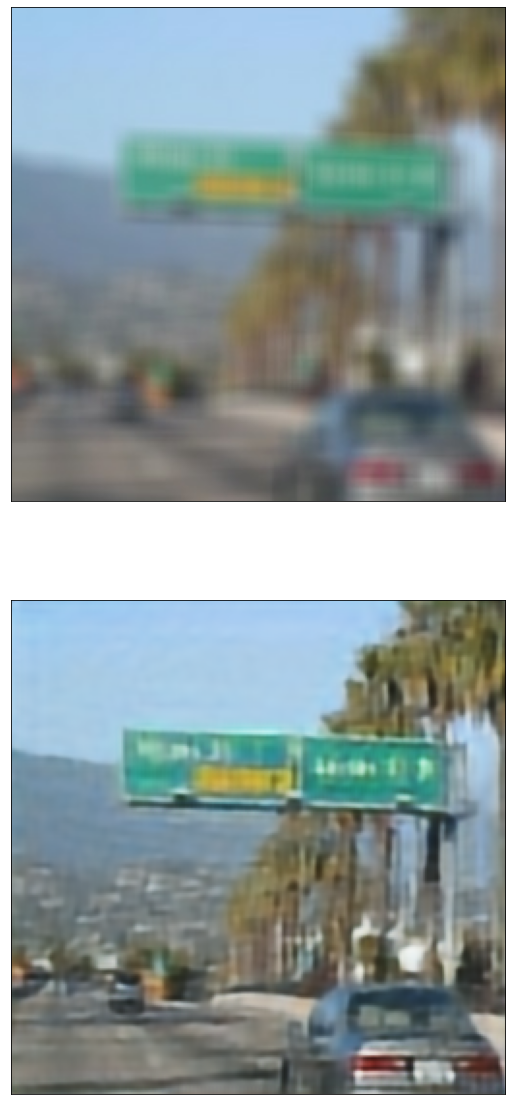

In [25]:
plotPrediccion( datasetValidation.take(1), predictions)

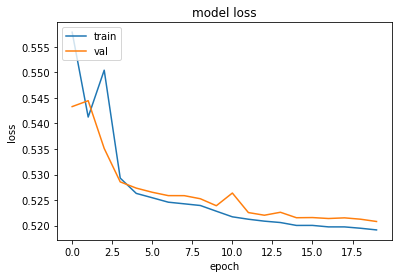

In [26]:
plt.plot(historia.history['loss'])
plt.plot(historia.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()